# Разработка A/B-тестирования и анализ результатов

- **Автор:** Алиса Гизова
- **Дата:** 10.06.2025

### Контекст:
В развлекательном приложении с контентом в формате "бесконечной" ленты используется гибридная модель монетизации: платная подписка (убирает рекламу) и показ рекламы неподписанным пользователям. Разработан новый алгоритм рекомендательной системы, который должен повысить релевантность выдачи контента.

### Цель:
Оценить влияние нового алгоритма на ключевые бизнес-метрики и поведение пользователей с помощью корректно спланированного и проведённого A/B-теста.

### Задачи:
- Расчёт параметров теста
- Оценка корректности проведения
- Анализ результатов

## Работа с историческими данными

### Загрузка исторических данных

In [4]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [6]:
# Выводим первые строки датафрейма на экран
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [7]:
# Выводим информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


### Знакомство с данными

Проверим данные на наличие дубликатов.

In [10]:
# Проверяем полные дубликаты в датафрейме
sessions_history.duplicated().sum()

0

В датафрейме нет полных дубликатов строк. 

In [12]:
# Рассчитываем количество уникальных сессий для каждого пользователя
user_sessions = sessions_history.groupby('user_id')['session_id'].nunique()

In [13]:
# Находим пользователя с максимальным количеством сессий
max_sessions_user = user_sessions.idxmax()

In [14]:
# Выводим все данные для пользователя с максимальным количеством сессий
sessions_history[sessions_history['user_id'] == max_sessions_user]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


**Анализ данных конкретного пользователя позволит понять:**

- Как распределены сессии по датам (`session_date`);
- Как ведет себя `session_number` (должен увеличиваться с каждой новой сессией);
- Соотношение зарегистрированных и незарегистрированных сессий (`registration_flag`);
- Количество просмотренных страниц (`page_counter`) в разных сессиях;
- Регион и устройство пользователя (должны быть постоянными для одного пользователя).

### Анализ числа регистраций

In [17]:
# Создаем датафрейм с уникальными пользователями по дням
daily_users = sessions_history.groupby(['session_date', 'user_id'])['registration_flag'].max().reset_index()

In [18]:
# Агрегируем данные по дням
daily_stats = daily_users.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

In [19]:
# Рассчитываем долю зарегистрированных пользователей
daily_stats['registration_rate'] = daily_stats['registered_users'] / daily_stats['total_users']

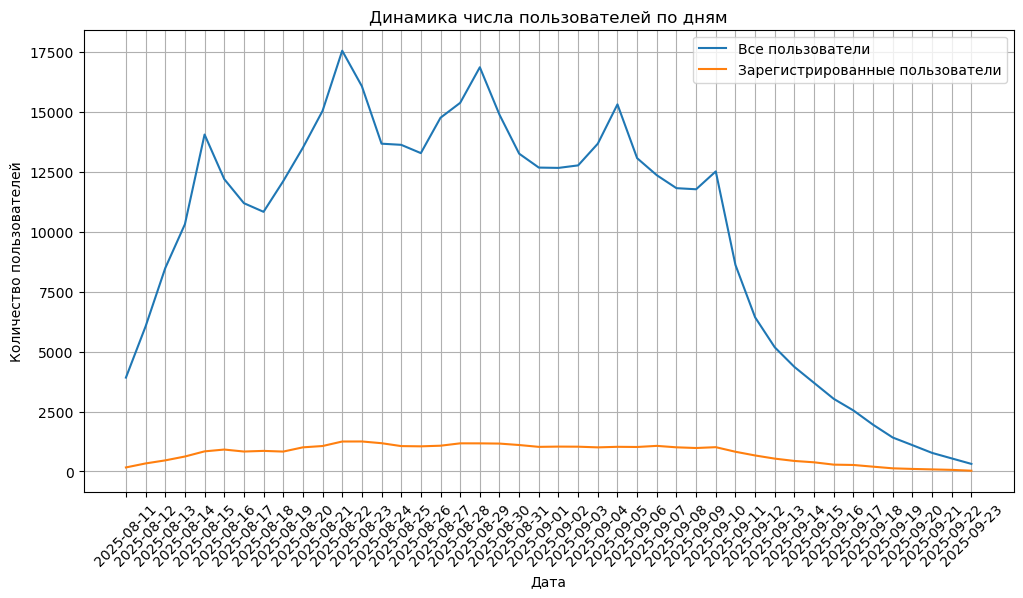

In [20]:
# График общего числа пользователей и зарегистрированных пользователей по дням
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Все пользователи')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Зарегистрированные пользователи')

plt.title('Динамика числа пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

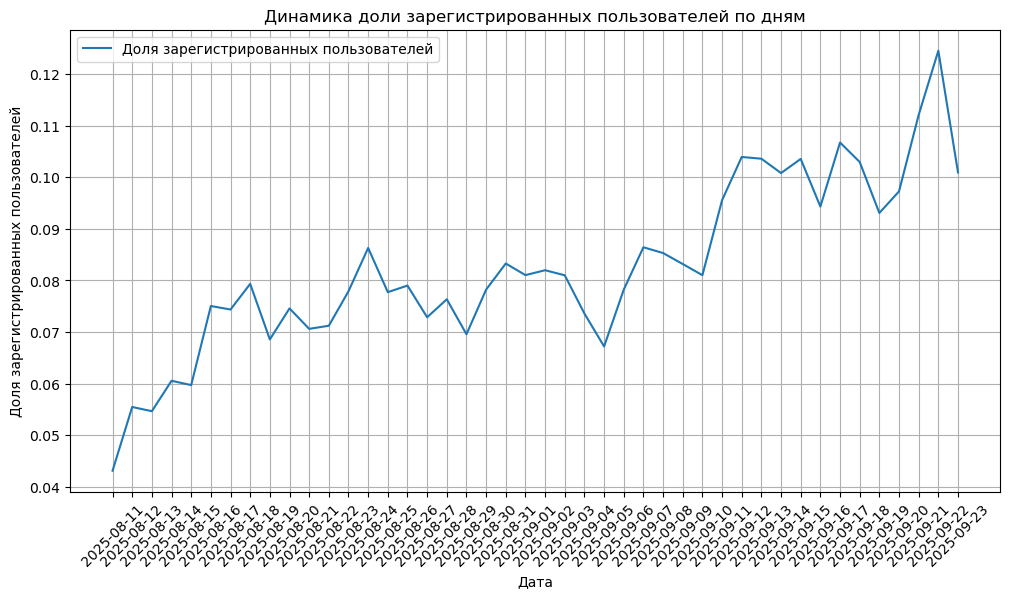

In [21]:
### График доли зарегистрированных пользователей по дням
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['registration_rate'], label='Доля зарегистрированных пользователей')

plt.title('Динамика доли зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

**Динамика пользователей**:
   - Первый график показывает абсолютные значения общего числа пользователей и зарегистрированных пользователей по дням;
   - Можно наблюдать тренды роста/падения пользовательской базы;
   - Начиная с 2025-09-09 общее число пользователей резко уменьшается.

**Доля регистраций**:
   - Второй график показывает процент зарегистрированных пользователей от общего числа;
   - Доля регистраций, начиная с 2025-09-09, растет - это может быть связано с резким уменьшением общего числа пользователей;
   - Резкие скачки могут быть связаны с маркетинговыми акциями или изменениями в продукте.

### Анализ числа просмотренных страниц

In [24]:
# Рассчитываем количество сессий для каждого значения количества просмотренных страниц
page_counts = sessions_history['page_counter'].value_counts().sort_index()

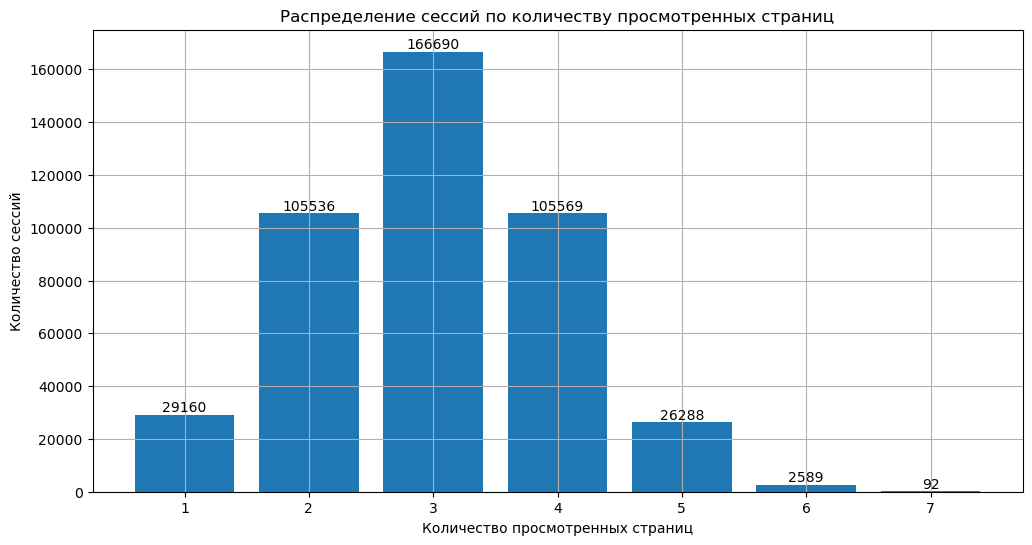

In [25]:
# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
bars = plt.bar(page_counts.index, page_counts.values)

# Добавим подписи значений над столбцами
for i, v in enumerate(page_counts.values):
    plt.text(page_counts.index[i], v, str(v), ha='center', va='bottom')

plt.title('Распределение сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid()
plt.show()

**Распределение просмотров страниц**:
   - График показывает, как часто пользователи просматривают определенное количество страниц за сессию;
   - Пиковые значения обычно приходятся на небольшие количества страниц (2-4);
   - Резкое падение количества сессий, начиная с 5 страниц, может указывать на ограничения в продукте или на особенности пользовательского поведения.

### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

In [28]:
# Создаем столбец good_session
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

In [29]:
# Рассчитываем долю успешных сессий по дням
daily_good_sessions = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

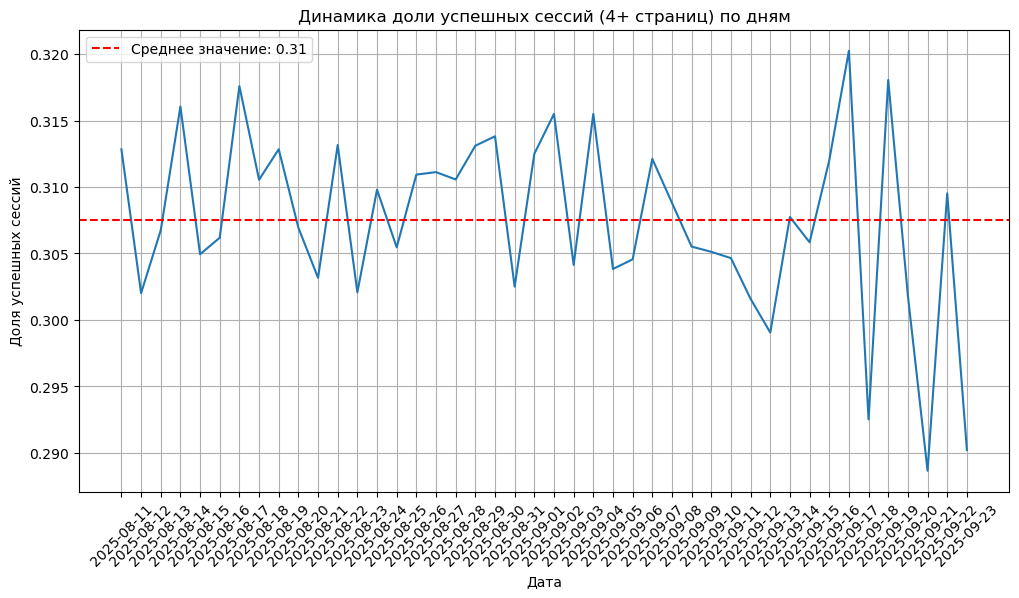

In [30]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['session_date'], 
         daily_good_sessions['good_session'])

plt.title('Динамика доли успешных сессий (4+ страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=45)
plt.grid()

# Добавляем горизонтальную линию среднего значения
mean_value = daily_good_sessions['good_session'].mean()
plt.axhline(y=mean_value, color='r', linestyle='--', 
            label=f'Среднее значение: {mean_value:.2f}')
plt.legend()
plt.show()

**Метрика `good_session`** помогает количественно оценить вовлеченность пользователей.

**Динамика по дням**:
   - График показывает, как меняется доля успешных сессий с течением времени;
   - Резкие колебания могут быть связаны с изменениями в продукте или внешними факторами.

**Среднее значение**:
   - Вычисленная средняя доля успешных сессий будет важным показателем для A/B-теста;
   - Новый алгоритм рекомендаций должен показать статистически значимое улучшение этого показателя;
   - Значение 0.31 может указывать на проблемы с контентом или рекомендациями.

## Подготовка к тесту

### Расчёт размера выборки

In [34]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


Полученное значение показывает, сколько пользователей должно быть в каждой группе (контрольной и тестовой).

### Расчёт длительности A/B-тест

In [37]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {round(avg_daily_users)} пользователей в день составит {test_duration} дня.")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 4 дня.


## Мониторинг А/В-теста

### Проверка распределения пользователей

In [40]:
# Рассчитываем количество уникальных пользователей в каждой группе
users_per_group = sessions_test_part.groupby('test_group')['user_id'].nunique()

In [41]:
# Выводим распределение пользователей
print("Количество пользователей по группам:")
print(users_per_group)

Количество пользователей по группам:
test_group
A    1477
B    1466
Name: user_id, dtype: int64


In [42]:
# Рассчитываем процентную разницу
A = users_per_group.get('A', 0)  # Контрольная группа
B = users_per_group.get('B', 0)  # Тестовая группа
P = 100 * (abs(A - B) / A) if A != 0 else 0

print(f"\nПроцентная разница в размерах групп: {P:.2f}%")


Процентная разница в размерах групп: 0.74%


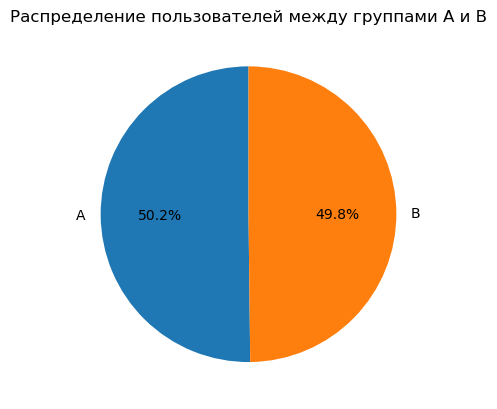

In [43]:
# Визуализация распределения
plt.pie(users_per_group, 
        labels=users_per_group.index, 
        autopct='%1.1f%%',
        startangle=90)
plt.title('Распределение пользователей между группами A и B')
plt.show()

Группы A (контрольная) и B (тестовая) примерно равны.

### Проверка пересечений пользователей

In [46]:
# Создаем множества пользователей из каждой группы
users_group_a = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
users_group_b = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())

# Находим пересечение пользователей
common_users = users_group_a & users_group_b
num_common_users = len(common_users)

if num_common_users > 0:
    print(f"Обнаружено {num_common_users} пользователей, присутствующих в обеих группах:")
    print(common_users)
    
    # Выводим данные проблемных пользователей для анализа
    print("\nДанные пересекающихся пользователей:")
    display(sessions_test_part[sessions_test_part['user_id'].isin(common_users)].sort_values('user_id'))
else:
    print("Пересечений пользователей между группами не обнаружено.")

Пересечений пользователей между группами не обнаружено.


### Равномерность разделения пользователей по устройствам

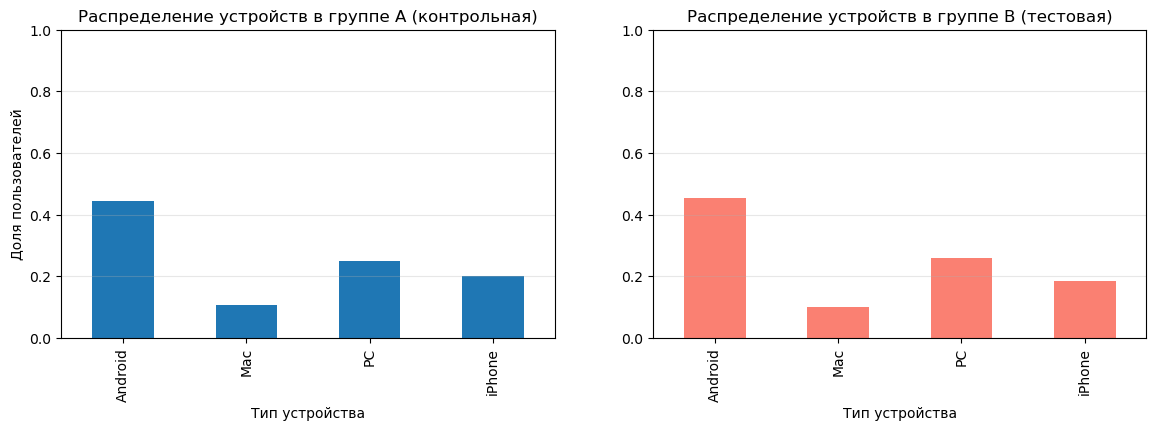

In [48]:
# Создаем сводную таблицу по распределению устройств в группах
device_distribution = sessions_test_part.drop_duplicates('user_id').groupby(['test_group', 'device'])['user_id'].size().unstack()

# Нормализуем для получения долей
device_distribution_normalized = device_distribution.div(device_distribution.sum(axis=1), axis=0)

# Визуализация
plt.figure(figsize=(14, 4))

# График для группы A
plt.subplot(1, 2, 1)
device_distribution_normalized.loc['A'].plot(
    kind='bar',
    title='Распределение устройств в группе A (контрольная)'
)
plt.ylabel('Доля пользователей')
plt.xlabel('Тип устройства')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# График для группы B
plt.subplot(1, 2, 2)
device_distribution_normalized.loc['B'].plot(
    kind='bar', 
    color='salmon',
    title='Распределение устройств в группе B (тестовая)'
)
plt.xlabel('Тип устройства')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

plt.show()

Столбцы имеют примерно одинаковую высоту на обеих диаграммах. Это указывает на то, что пользователи в группах равномерно распределены по типам устройств.

### Равномерность распределения пользователей по регионам

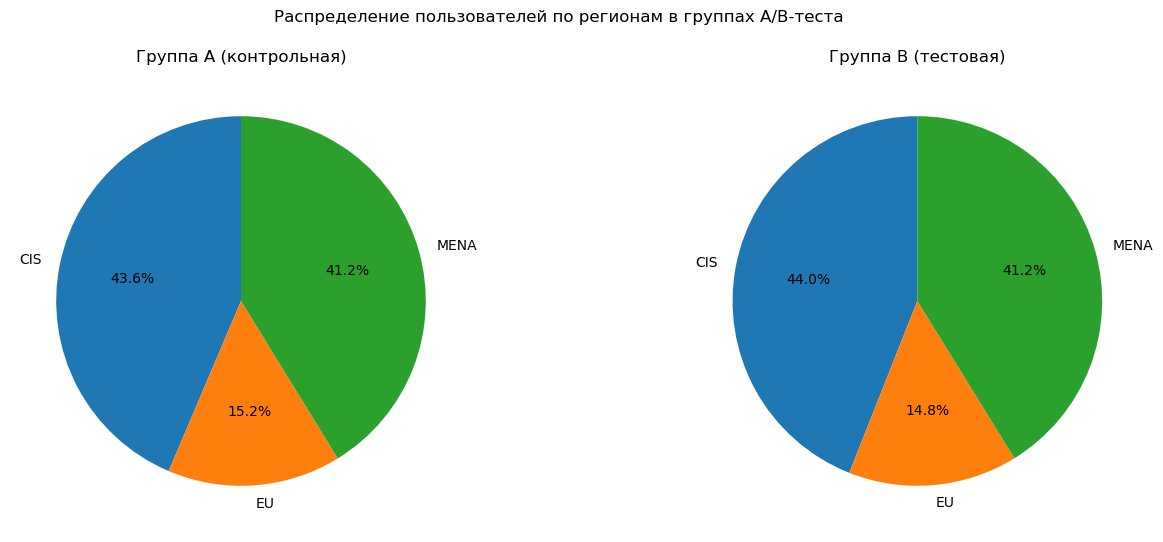

In [51]:
# Подготовка данных
region_dist = sessions_test_part.drop_duplicates('user_id').groupby(['test_group', 'region'])['user_id'].size().unstack()
region_dist_normalized = region_dist.div(region_dist.sum(axis=1), axis=0)

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Распределение пользователей по регионам в группах A/B-теста')

# Круговая диаграмма для группы A
ax1.pie(
    region_dist_normalized.loc['A'],
    labels=region_dist_normalized.columns,
    autopct='%1.1f%%',
    startangle=90,
)
ax1.set_title('Группа A (контрольная)')

# Круговая диаграмма для группы B
ax2.pie(
    region_dist_normalized.loc['B'],
    labels=region_dist_normalized.columns,
    autopct='%1.1f%%',
    startangle=90,
)
ax2.set_title('Группа B (тестовая)')

plt.show()

Соответствующие сегменты на обеих диаграммах имеют схожий размер. Это указывает на то, что пользователи в группах равномерно распределены по регионам.

### Окончательные выводы по проверке корректности проведения A/B-теста

**Баланс количества пользователей между группами:**
   - Разница в размерах групп составила **0.74%** (1466 vs 1477 пользователей);
   - *Вывод:* Распределение пользователей по количеству является статистически равномерным.

**Независимость выборок:**
   - Пересечение пользователей между группами: **не обнаружено**;
   - Все пользователи последовательно относятся только к одной группе;
   - *Вывод:* Выборки можно считать полностью независимыми.

**Распределение по устройствам:**
   - Визуальный анализ не показал существенных различий;
   - *Вывод:* Распределение по устройствам равномерное между группами.

**Распределение по регионам:**
   - Визуальный анализ не показал существенных различий;
   - *Вывод:* Региональное распределение статистически сбалансировано.

**Заключение о корректности теста:**
   На основании комплексного анализа всех параметров можно сделать вывод, что:
   - A/B-тест проводится корректно;
   - Все ключевые параметры распределения находятся в норме;
   - Критических нарушений не обнаружено.

## Проверка результатов A/B-теста

### Получение результатов теста и подсчёт основной метрики

In [56]:
# Создание столбца good_session
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

In [57]:
# Проверка результатов
print(f"Общее количество сессий: {len(sessions_test)}")
print(f"Доля успешных сессий (4+ страниц): {sessions_test['good_session'].mean():.2%}")
print("\nПервые 5 строк данных:")
display(sessions_test.head())

Общее количество сессий: 100005
Доля успешных сессий (4+ страниц): 31.31%

Первые 5 строк данных:


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


In [58]:
# Рассчитываем количество уникальных пользователей в каждой группе
users_per_group = sessions_test.groupby('test_group')['user_id'].nunique()

# Выводим распределение пользователей
print("Количество пользователей по группам:")
print(users_per_group)
print("Суммарное количество пользователей:")
print(sum(users_per_group))

Количество пользователей по группам:
test_group
A    15163
B    15416
Name: user_id, dtype: int64
Суммарное количество пользователей:
30579


### Проверка корректности результатов теста

In [60]:


# Рассчитываем количество уникальных сессий по дням и группам
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()

# Проверка равенства средних с помощью t-теста
t_stat, p_value = ttest_ind(daily_sessions['A'], daily_sessions['B'], equal_var=False)

print(f"p-value = {p_value:.4f}")

# Интерпретация результатов
if p_value < 0.05:
    print("\nОбнаружены статистически значимые различия в количестве сессий между группами.")
    print("Рекомендуется проверить механизм распределения пользователей по группам.")
else:
    print("\nСтатистически значимых различий в количестве сессий между группами не обнаружено.")
    print("Распределение сессий по дням между группами можно считать равномерным.")

p-value = 0.9382

Статистически значимых различий в количестве сессий между группами не обнаружено.
Распределение сессий по дням между группами можно считать равномерным.


### Сравнение доли успешных сессий

In [62]:
# Рассчитываем метрики по группам
group_stats = sessions_test.groupby('test_group')['good_session'].agg(
    total_sessions='count',
    good_sessions='sum',
    good_rate='mean'
)

# Вычисляем разницу между группами
rate_diff = (group_stats.loc['B', 'good_rate'] - group_stats.loc['A', 'good_rate']) * 100
rel_diff = rate_diff / group_stats.loc['A', 'good_rate']

# Выводим результаты
print(f"Результаты сравнения:")
print(f"Группа A (контрольная): {group_stats.loc['A', 'good_rate']:.2%}")
print(f"Группа B (тестовая): {group_stats.loc['B', 'good_rate']:.2%}")
print(f"\nАбсолютная разница: {rate_diff:.2f}%")
print(f"Относительная разница: {rel_diff:.2f}%")

Результаты сравнения:
Группа A (контрольная): 30.77%
Группа B (тестовая): 31.83%

Абсолютная разница: 1.06%
Относительная разница: 3.43%


### Насколько статистически значимо изменение ключевой метрики

In [64]:

# Подготовка данных
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_a = sessions_test[sessions_test['test_group'] == 'A'].shape[0]
success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_b = sessions_test[sessions_test['test_group'] == 'B'].shape[0]

# Проведение z-теста для пропорций
z_stat, p_value = proportions_ztest([success_b, success_a], [total_b, total_a])

# Вывод результатов
print(f"Результаты статистического теста:")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("\nВывод: Изменение статистически значимо (p < 0.05).")
    if z_stat > 0:
        print("Новый алгоритм достоверно увеличил долю успешных сессий.")
    else:
        print("Новый алгоритм достоверно уменьшил долю успешных сессий.")
else:
    print("\nВывод: Изменение статистически не значимо (p ≥ 0.05).")

Результаты статистического теста:
p-value = 0.0003

Вывод: Изменение статистически значимо (p < 0.05).
Новый алгоритм достоверно увеличил долю успешных сессий.


## Окончательные выводы по результатам A/B-эксперимента

**Характеристики эксперимента:**
- Продолжительность теста: 20 дней (с 2025-10-14 по 2025-11-02);
- Общее количество пользователей: 30579 (15163 в группе A, 15416 в группе B);
- Количество проанализированных сессий: 100005;
- Ключевая метрика: доля сессий с просмотром ≥4 страниц (`good_session`).

**Влияние нового алгоритма:**
- Контрольная группа (A): 30.77% успешных сессий;
- Тестовая группа (B): 31.83% успешных сессий;
- **Абсолютный прирост:** +1.06%;
- **Относительное улучшение:** +3.43%.

**Статистическая значимость:**
- p-value = 0.0003;
- Изменение статистически значимо (p < 0.05);
- Новый алгоритм достоверно **увеличил** долю успешных сессий.

**Рекомендации для команды разработки:**

**Внедрить новый алгоритм рекомендаций** по следующим причинам:
- Статистически значимое улучшение ключевой метрики;
- Равномерное распределение пользователей подтверждает чистоту эксперимента;
- Перед внедрением необходимо проверить влияние нового алгоритма на вторичные метрики.

**Заключение:**
Эксперимент успешно подтвердил гипотезу о том, что новый алгоритм рекомендаций увеличивает вовлеченность пользователей. Полученные результаты позволяют рекомендовать его к полноценному внедрению в приложение.